# Imports

In [1]:
import tweepy
import sys, os
import emoji
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sn
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from scipy import stats
from emoji import UNICODE_EMOJI, EMOJI_UNICODE
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
try:
    import json
except ImportError:
    import simplejson as json

# If you are using windows make sure you are using this version specifically: https://github.com/FintelLabs/emosent-py/issues/2
# python -m pip install https://github.com/FintelLabs/emosent-py/archive/e5788e73e88f691b44fd5f6eda72187b559d99f2.tar.gz
from emosent import get_emoji_sentiment_rank

# Authentication
Here we create the variables that contains the user credentials to access Twitter API. You must obtain these yourself by applying for a developer at https://developer.twitter.com/en/apply-for-access. To practice safe authentication this notebook uses Twitter's recommended way of doing it, by storing your secrets in your environment variables. Once you have done this you can access the api using the following code block.

In [2]:
# Retrieve user credentials
ACCESS_TOKEN = os.environ.get("access_token")       # YOUR ACCESS TOKEN
ACCESS_SECRET = os.environ.get("access_secret")     # YOUR ACCESS TOKEN SECRET
CONSUMER_KEY = os.environ.get("consumer_key")       # YOUR API KEY
CONSUMER_SECRET = os.environ.get("consumer_secret") # YOUR API SECRET

# Setup tweepy to authenticate 
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

# Create the api to connect to twitter
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)

In [3]:
# Tweet user timeline as an example
status_list = []
for status in tweepy.Cursor(api.home_timeline).items(3):
    status_list.append(status._json)
    
tweet = status_list[0]
tweet_text = tweet['text']
print("\nTEXT: ", tweet_text)

hashtags = tweet['entities']['hashtags']
print("HASHTAGS: ", hashtags)

urls = tweet['entities']['urls']
print("URLS: ", urls)


TEXT:  I should use some hashtags to be honest #laughter 😀
HASHTAGS:  [{'text': 'laughter', 'indices': [40, 49]}]
URLS:  []


# Main Code

## Emoji Creation
If you want to select tweets with certain emojis, you can use the following functions to define that emoji list.

In [4]:
def createEmojiList():
    emoji_list = []
    string_emoji_list = [':joy:',':heart:',':heart_eyes:',':sob:',':recycle:',':hearts:',':two_hearts:',':unamused:',':kissing_heart:',':pensive:']
    for stringEmoji in string_emoji_list:
        emoji_list.append(emoji.emojize(stringEmoji, use_aliases=True))
    return emoji_list

emoji_list = createEmojiList()
print(emoji_list)

['😂', '❤', '😍', '😭', '♻', '♥', '💕', '😒', '😘', '😔']


## Tweet Functions
These functions are all operations on tweets or tweet text. They are used for preprocessing and selecting tweets.

In [5]:
def cleanTweetJson(tweet, removeRetweets=True, removeURLs=True, removeMentions=False, removeHashtags=False):
    if removeRetweets or removeURLs or removeMentions:
        remove_list = []
        for data in tweet:
            if 'entities' in data:
                entities = tweet['entities']
                for ent in entities:
                    if 'user_mentions' in ent and removeMentions:
                        mentions = entities['user_mentions']
                        for mention in mentions:
                            remove_list.append("@" + mention['screen_name'])
                    if 'hashtags' in ent and removeHashtags:
                        hashtags = entities['hashtags']
                        for hashtag in hashtags:
                            remove_list.append("#" + hashtag['text'])
                    if 'symbols' in ent and removeHashtags:
                        symbols = entities['symbols']
                        for symbol in symbols:
                            remove_list.append("$" + symbol['text'])
                    if 'urls' in ent and removeURLs:
                        urls = entities['urls']
                        for url in urls:
                            remove_list.append(url['url']) 
    tweet_text = tweet['text']  
    for rem in remove_list:
        tweet_text = tweet_text.replace(rem, '')
    return tweet_text

def cleanTweetText(tweet_text, removeRetweets=True, removeURLs=True, removeMentions=False):   
    if removeRetweets:
        tweet_text = tweet_text.replace("RT ", '')
    if removeURLs:
        tweet_text = re.sub(r"http\S+", '', tweet_text, flags=re.MULTILINE) # Remove URLs
        tweet_text = re.sub(r'https?:\/\/\S*', '', tweet_text, flags=re.MULTILINE) # Remove URLs
    
    tweet_text = ' '.join(tweet_text.split()) # Merge multiple spaces into one space 
    tweet_text = tweet_text.lstrip(' ') # Remove leading spaces
    tweet_text = tweet_text.replace('\t', ' ') # Remove tabs
    tweet_text = tweet_text.replace('\n', ' ') # Remove enters
    return tweet_text

def cleanTweet(tweet, removeRetweets=True, removeURLs=True, removeMentions=False):
    tweet_text = cleanTweetJson(tweet)
    clean_text = cleanTweetText(tweet_text)
    return clean_text

def containsEmoji(tweet_text):
    return emoji.emoji_count(tweet_text) >= 1    

def isRetweet(tweet): 
    return hasattr(tweet, 'retweeted_status')
    
def isQuote(tweet):
    return hasattr(tweet, 'is_quoted_status')

def validTweet(tweet):
    tweet_text = tweet['text']
    if isRetweet(tweet) or isQuote(tweet):
        return False
    if not containsEmoji(tweet_text):
        return False
    return True

## Approximation Methods
These functions are the methods used to approximate the ground truth. Three different methods to approximate the ground truth are available: "VADER", "EMOJI" and "COMBINED". VADER is the VADER lexicon and rule-based sentiment analysis tool. EMOJI is a ranking based on the average sentiment score of all present emojis in a tweet, which is based on the Emoji Sentiment Ranking. COMBINED is a linear combination of the previous two methods, where an equal weight is given to the methods.

In [6]:
def tweetValence(tweet_text, metric, emoji_weight=0.5):
    metric = metric.upper()
    if metric == "VADER":
        return vaderValence(tweet_text)
    elif metric == "EMOJI":
        return emojiRankingValence(tweet_text)
    elif metric == "COMBINED": # Linear combination of the two methods if the tweet contains an emoji
        if (containsEmoji(tweet_text)):
            vader_weight = 1-emoji_weight
            return (vaderValence(tweet_text) * vader_weight + emojiRankingValence(tweet_text) * emoji_weight)
        else:
            return vaderValence(tweet_text)

    
# Convert the [-1.0 ... 1.0] range to [0.0 ... 1.0] 
def convertRange(num):
    return (num+1) / 2

def vaderValence(tweet_text):
    vader = SentimentIntensityAnalyzer()
    return convertRange(vader.polarity_scores(text=tweet_text)['compound'])

def emojiRankingValence(tweet_text):
    emoji_list = [em for em in tweet_text if em in emoji.UNICODE_EMOJI]
    sentiment_score_list = []
    if len(emoji_list) >= 1:
        for em in emoji_list:
            try: 
                sentiment_score_list.append(get_emoji_sentiment_rank(em)['sentiment_score'])
            except KeyError: # If the emoji is not found in the ranking
                pass
    if len(sentiment_score_list) <= 0:
        return 0.5
    else: 
        return convertRange(sum(sentiment_score_list) / len(sentiment_score_list))

# Twitter Stream
These methods are based on tweepy and the twitter api. Together they make it possible to access twitter data in real time.

In [7]:
class Listener(tweepy.StreamListener):
    def __init__(self, metric="VADER", output_file='results.txt', show_progress=True, tweet_limit=100, dataset_limit=10):
        super(Listener,self).__init__()
        self.limit_counter = 0
        self.tweet_limit = tweet_limit
        self.tweet_counter = 0
        self.dataset_limit = dataset_limit   
        self.metric = metric
        self.output_filehandle = open(output_file, 'wb')
        
    def limit_stream(self):
        self.limit_counter += 1
        if self.limit_counter < self.tweet_limit:
            return True
        else:
            print("\nMAX TWEET SAMPLE LIMIT REACHED")
            self.output_filehandle.close()
            
    def limit_dataset(self):
        self.tweet_counter += 1
        if self.tweet_counter < self.dataset_limit:
            return True
        else:
            print("\nMAX DATASET SIZE REACHED")
            self.output_filehandle.close()
        
    def on_status(self, status):
        if not self.limit_stream():
            return False
        tweet = status._json
        if validTweet(tweet):
            self.extractData(tweet)
            if not self.limit_dataset():
                return False
            
    def on_error(self, status_code):
        print(status_code)
        if status_code == 420:
            print("\nYOU ARE AT YOUR TWITTER DEV API LIMIT")
        return False

    def formatDataRow(self, clean_text, ID="ID",  descriptor="valence", valence=0.0):
        return (ID + '\t' + clean_text + '\t' + descriptor + '\t' + str(valence) + "\r\n").encode('utf-8')

    def extractData(self, tweet, show_processed_tweets=True):
        clean_text = cleanTweet(tweet) 
        valence = tweetValence(clean_text, self.metric) # Valence between 0.0 - 1.0
        if show_processed_tweets:
            print("TWEET ", self.tweet_counter+1, "/", self.dataset_limit, ": ", clean_text)
        self.output_filehandle.write(self.formatDataRow(clean_text, valence=valence))

In [8]:
def runSampleStream(metric="VADER", output_file="dataset.txt", show_progress=True, tweet_cap_usage = 100, dataset_size=10):
    listener = Listener(metric=metric, output_file=output_file, show_progress=True, tweet_limit=tweet_cap_usage, dataset_limit=dataset_size)
    stream = tweepy.Stream(auth=api.auth, listener=listener)
    try:
        print('START STREAMING\n')
        stream.sample(languages=['en'])
    except KeyboardInterrupt:
        print("\nSTOPPED DUE TO KEYBOARD INTERRUPT")
    finally:
        stream.disconnect()
        print('\nDONE STREAMING')

def runFilterStream(filter_list, metric="VADER",output_file="dataset.txt", show_progress=True, tweet_cap_usage = 100, dataset_size=10):
    listener = Listener(metric=metric, output_file=output_file, show_progress=True, tweet_limit=3)
    stream = tweepy.Stream(auth=api.auth, listener=listener)
    try:
        print('START STREAMING\n')
        stream.filter(track=filter_list, languages=['en'])
    except KeyboardInterrupt:
        print("\nSTOPPED DUE TO KEYBOARD INTERRUPT")
    finally:
        stream.disconnect()
        print('\nDONE STREAMING')       

# Use Examples
This following functions will create a .txt data set that contains tweets with a minimum of 1 emoji. A minimal preprocessing is done on these tweets to produce a dataset with the same structure as Semeval-2018 Task 1. Three different methods to approximate the ground truth are available: "VADER", "EMOJI" and "COMBINED". 
## Sample Stream
The sampled stream endpoint delivers a roughly 1% random sample of publicly available Tweets in real-time. 

In [9]:
runSampleStream(metric="VADER", output_file="sample_output.txt", show_progress=True, tweet_cap_usage=100, dataset_size=10)

START STREAMING

TWEET  1 / 10 :  @FeistyPK2 Breaking news.... 🤣
TWEET  2 / 10 :  @I_am_Endeavour: This is the way! To deal with transphobic racists. Fantastic to see thank you @PedroPascal1 🏳️‍🌈🕺🏻🏳️‍⚧️
TWEET  3 / 10 :  @SkylightsYRA: Thanks Marcelo Bielsa ⚽ You're one of the greatest managers of all time, we're just a few lads having a go, it means a l…
TWEET  4 / 10 :  @therealaaliya: Good days are coming Good days are coming Good days are coming Good days are coming Good days are coming 🧘🏽‍♀️🧘🏽‍♀️…
TWEET  5 / 10 :  @amietorii Follow them quickly @SSharns @Jeremia36690681 @LisSumaili @danielmaviiin @EmmahWookie 🔥🔥
TWEET  6 / 10 :  Keep yer eyes peeled 👀
TWEET  7 / 10 :  @chiefbayen: My boy fine 🔥🔥🔥❤️
TWEET  8 / 10 :  @luciablancaflor: drivers license 🤍
TWEET  9 / 10 :  @Obi_Dadi: This how you do it when you beat CANCER 2x &amp; turn 6 in a PANDEMIC. Happy birthday son🎊🎊🎁🎁🎉🎉
TWEET  10 / 10 :  @JennaEllisEsq: This is one of many reasons I will never apologize for supporting President T

## Filter Stream
The filtered stream endpoint group enables developers to filter the real-time stream of public Tweets. This endpoint group’s functionality includes multiple endpoints that enable you to create and manage rules, and apply those rules to filter a stream of real-time Tweets that will return matching public Tweets.

In [10]:
runFilterStream(createEmojiList(), metric="EMOJI", output_file="filter_output.txt", tweet_cap_usage=100, dataset_size=10)

START STREAMING

TWEET  1 / 10 :  Indeed @PaulGotts...these longboats are circa. 2021! 😂
TWEET  2 / 10 :  @SkySportsPL: Kicking every ball 😂 @Carra23 and @GNev2 were as entertaining as ever at Anfield on Super Sunday 📸

MAX TWEET SAMPLE LIMIT REACHED

DONE STREAMING


# Dataset to Dataframe
For the data-savvy user, here is a function that will read the .txt into a pandas dataframe.

In [11]:
data = pd.read_csv("sample_output.txt", sep='\t', names=["ID", "Tweet", "Type", "Score"])
data

,ID,Tweet,Type,Score
0,ID,@FeistyPK2 Breaking news.... 🤣,valence,0.74695
1,ID,@I_am_Endeavour: This is the way! To deal with...,valence,0.71945
2,ID,@SkylightsYRA: Thanks Marcelo Bielsa ⚽ You're ...,valence,0.89820
3,ID,@therealaaliya: Good days are coming Good days...,valence,0.96300
4,ID,@amietorii Follow them quickly @SSharns @Jerem...,valence,0.20705
5,ID,Keep yer eyes peeled 👀,valence,0.50000
6,ID,@chiefbayen: My boy fine 🔥🔥🔥❤️,valence,0.17015
7,ID,@luciablancaflor: drivers license 🤍,valence,0.50000
8,ID,@Obi_Dadi: This how you do it when you beat CA...,valence,0.91510
9,ID,@JennaEllisEsq: This is one of many reasons I ...,valence,0.29885


# Analysis of Approximation Effectiveness
Here we will show how effective the ground truth approximation of the methods are. How well the tool approximates the ground truth will be evaluated by comparing it to the approximation on the human annotated SemEval-2018 Task 1: Affect in Tweets (AIT-2018) data set. The human annotated labels will thus be considered the Gold labels for the evaluation.

## Preprocessing of data
Load in the data and prepare it for analysis. This includes checking for duplicates and making sure every tweet contains an emoji.

In [12]:
df_dev = pd.read_csv("2018-Valence-reg-En-dev.txt", sep='\t', names=["ID", "Tweet", "Type", "Ground Truth"], skiprows=1)
df_test = pd.read_csv("2018-Valence-reg-En-train.txt", sep='\t', names=["ID", "Tweet", "Type", "Ground Truth"], skiprows=1)

In [13]:
def check_for_duplicates(df):
    # Check for any duplicate tweets, there should not be any
    duplicate_rows = df[df.duplicated(['Tweet'])]
    if duplicate_rows.size > 0:
        print("Duplicate tweets found, this should NOT happen!")
    return df
        
def remove_non_emoji_tweets(df):
    # Remove all tweets that don't contain an Emoji
    print("Dataset size including non-emoji tweets: ", df.shape[0])
    df_inc_non_emoji = df
    df["Contains Emoji"] = df["Tweet"].apply(lambda x: containsEmoji(x))
    df = df[df["Contains Emoji"]]
    df = df.drop(columns="Contains Emoji")
    print("Dataset size excluding non-emoji tweets: ", df.shape[0])
    return df, df_inc_non_emoji

def bin_score(score):
    if score >= 0.61:
        return 1
    elif score <= 0.429:
        return -1
    else:
        return 0

In [14]:
print("Development Set Stats:")
df_dev, __ = remove_non_emoji_tweets(check_for_duplicates(df_dev))
print("\nTest Set Stats:")
df_test, df_test_inc_non_emoji = remove_non_emoji_tweets(check_for_duplicates(df_test))

Development Set Stats:
Dataset size including non-emoji tweets:  449
Dataset size excluding non-emoji tweets:  127

Test Set Stats:
Dataset size including non-emoji tweets:  1181
Dataset size excluding non-emoji tweets:  136


In [15]:
df_test["Ground Truth Class"] = df_test["Ground Truth"].apply(lambda x: bin_score(x))

## Hyperparameter Tuning
Using the development set we can tune the single hyperparameter in the whole study: The weight for the linear combination in the COMBINED approximation method. The weight corresponds to how much weight the Emoji-based score is given to the final score, with 1.0 meaning the Emoji-based score represents 100% of the score.

In [16]:
step_size = 0.05
weights = np.arange(0.0, 1.0+step_size, step_size)
print("Weights Used For Tuning: ", weights)
for weight in weights:
    df_dev["COMBINED w=" + str(weight)[0:4] + " valence"] = df_dev["Tweet"].apply(lambda x: tweetValence(x, "COMBINED", weight))
df_dev

Weights Used For Tuning:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


,ID,Tweet,Type,Ground Truth,COMBINED w=0.0 valence,COMBINED w=0.05 valence,COMBINED w=0.1 valence,COMBINED w=0.15 valence,COMBINED w=0.2 valence,COMBINED w=0.25 valence,...,COMBINED w=0.55 valence,COMBINED w=0.60 valence,COMBINED w=0.65 valence,COMBINED w=0.70 valence,COMBINED w=0.75 valence,COMBINED w=0.8 valence,COMBINED w=0.85 valence,COMBINED w=0.9 valence,COMBINED w=0.95 valence,COMBINED w=1.0 valence
4,2018-En-00502,omg so grateful to have an education but ive b...,valence,0.672,0.34605,0.370697,0.395345,0.419992,0.44464,0.469287,...,0.617173,0.64182,0.666467,0.691115,0.715762,0.74041,0.765058,0.789705,0.814353,0.8390
7,2018-En-01354,@LoveMyFFAJacket FaceTime - we can still annoy...,valence,0.677,0.50000,0.505525,0.511050,0.516575,0.52210,0.527625,...,0.560775,0.56630,0.571825,0.577350,0.582875,0.58840,0.593925,0.599450,0.604975,0.6105
9,2018-En-01292,@VescioDiana You forgot #laughter as well ❤️❤️❤️,valence,0.700,0.82430,0.826735,0.829170,0.831605,0.83404,0.836475,...,0.851085,0.85352,0.855955,0.858390,0.860825,0.86326,0.865695,0.868130,0.870565,0.8730
12,2018-En-00459,Wtf shawty ass on 😤,valence,0.188,0.09630,0.111210,0.126120,0.141030,0.15594,0.170850,...,0.260310,0.27522,0.290130,0.305040,0.319950,0.33486,0.349770,0.364680,0.379590,0.3945
14,2018-En-01474,Didn't know the @ChickfilA cow day thing ended...,valence,0.397,0.92420,0.907490,0.890780,0.874070,0.85736,0.840650,...,0.740390,0.72368,0.706970,0.690260,0.673550,0.65684,0.640130,0.623420,0.606710,0.5900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2018-En-00900,I am shy at first.It usually takes me a few mi...,valence,0.500,0.37500,0.389575,0.404150,0.418725,0.43330,0.447875,...,0.535325,0.54990,0.564475,0.579050,0.593625,0.60820,0.622775,0.637350,0.651925,0.6665
435,2018-En-03236,@andyfleming83 Bastard squirrels. 😡,valence,0.141,0.22885,0.238082,0.247315,0.256547,0.26578,0.275012,...,0.330408,0.33964,0.348872,0.358105,0.367337,0.37657,0.385802,0.395035,0.404267,0.4135
436,2018-En-02462,"Dannie you're a terrible influence, piercing t...",valence,0.516,0.47420,0.482940,0.491680,0.500420,0.50916,0.517900,...,0.570340,0.57908,0.587820,0.596560,0.605300,0.61404,0.622780,0.631520,0.640260,0.6490
439,2018-En-02551,The next time I go to Lagos I will gate crash ...,valence,0.648,0.23665,0.241968,0.247285,0.252603,0.25792,0.263238,...,0.295143,0.30046,0.305777,0.311095,0.316412,0.32173,0.327047,0.332365,0.337682,0.3430


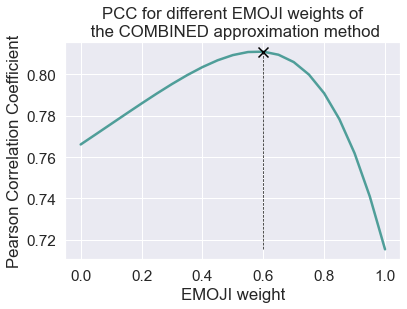

Best Emoji Weight:  0.6000000000000001 , with PCC:  0.8109526716343498


In [17]:
weighted_scores = ["COMBINED w=" + str(weight)[0:4] + " valence" for weight in weights]
weighted_correlations = [df_dev["Ground Truth"].corr(df_dev[score], method="pearson") for score in weighted_scores]
# print(weighted_scores)
# print(weighted_correlations)

sn.set(font_scale=1.4) # for label size
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('EMOJI weight')
plt.title('PCC for different EMOJI weights of\n the COMBINED approximation method')

index_best = np.argmax(weighted_correlations)
best_emoji_weight = weights[np.argmax(weighted_correlations)]
best_pcc = np.max(weighted_correlations)

plt.scatter(weights[index_best], weighted_correlations[index_best], marker='x',  zorder=2, c='black', s=100)
plt.plot(weights, weighted_correlations, color=(0.31, 0.62, 0.60),  zorder=1, lw=2.5)
plt.plot([weights[index_best], best_emoji_weight], [np.min(weighted_correlations), weighted_correlations[index_best]], linestyle='--', color='k', lw=0.75)
plt.show()

print("Best Emoji Weight: ", best_emoji_weight, ", with PCC: ", best_pcc)

## Data Visualization
In the following histograms the training set and the same dataset with only the entries that contain emojis is shown. As you can see the valence in the dataset with only tweets that that contain emojis is differently distributed, it is a contains less tweets that are fairly neutral, i.e. a valence close to 0.5. 

In [18]:
metrics = ["EMOJI" ,"VADER", "COMBINED"]
for metric in metrics:
    df_test[metric + " valence"] = df_test["Tweet"].apply(lambda x: tweetValence(x, metric, best_emoji_weight))
    df_test[metric + " Class"] = df_test["Tweet"].apply(lambda x: bin_score(tweetValence(x, metric, best_emoji_weight)))

df_test

,ID,Tweet,Type,Ground Truth,Ground Truth Class,EMOJI valence,EMOJI Class,VADER valence,VADER Class,COMBINED valence,COMBINED Class
4,2017-En-30838,i was so embarrassed when she saw us i was lik...,valence,0.233,-1,0.316000,-1,0.68670,1,0.464280,0
6,2017-En-20210,I hate having ideas but being too afraid to sh...,valence,0.138,-1,0.427000,-1,0.61315,1,0.501460,0
44,2017-En-30420,@Corsair those sparkling looks like a gay vamp...,valence,0.677,1,0.725000,1,0.88585,1,0.789340,1
46,2017-En-31213,@SquishyJiminie aww thank you!! I'm definitely...,valence,0.776,1,0.829000,1,0.96900,1,0.885000,1
52,2017-En-40771,"Please bear with me, I'm not Twitter savvy😝 in...",valence,0.517,0,0.712500,1,0.86755,1,0.774520,1
...,...,...,...,...,...,...,...,...,...,...,...
1122,2017-En-31451,That was a lovely story to actually see Ruth a...,valence,0.900,1,0.822500,1,0.98400,1,0.887100,1
1126,2017-En-31600,semores: let's get this. #mirth #SAW #keepthet...,valence,0.483,0,0.753818,1,0.98100,1,0.844691,1
1159,2017-En-21094,@pixietangerine @hatersbackoff im so exited!! ...,valence,0.964,1,0.839000,1,0.96125,1,0.887900,1
1163,2017-En-22138,@kcbbcxo don't get discouraged! it's early on ...,valence,0.655,1,0.822500,1,0.95040,1,0.873660,1


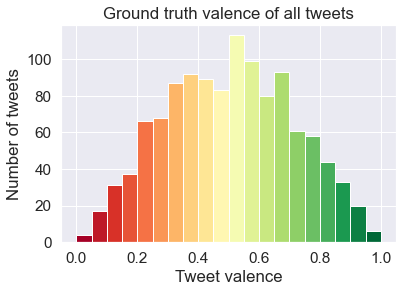

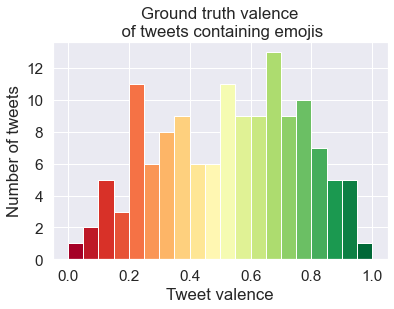

Average ground truth valence of all tweets: 			 0.5005080440304825
Average ground truth valenceof tweets containing emojis: 	 0.5298382352941176
Ks_2sampResult(statistic=0.11023808337899088, pvalue=0.0949975564115425)


In [19]:
def plot_hist(dataframe, title, column="Ground Truth", bins=20):
    cm = plt.cm.get_cmap('RdYlGn')
    n, bins, patches = plt.hist(dataframe[column], bins, range=(0, 1))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    
    plt.ylabel('Number of tweets')
    plt.xlabel('Tweet valence')
    plt.title(title)
    plt.show()
    
plot_hist(dataframe=df_test_inc_non_emoji, title='Ground truth valence of all tweets', column="Ground Truth")
plot_hist(dataframe=df_test, title='Ground truth valence\n of tweets containing emojis', column="Ground Truth")


print("Average ground truth valence of all tweets: \t\t\t", df_test_inc_non_emoji["Ground Truth"].mean())
print("Average ground truth valenceof tweets containing emojis: \t", df_test["Ground Truth"].mean())
print(stats.ks_2samp(df_test_inc_non_emoji["Ground Truth"], df_test["Ground Truth"]))


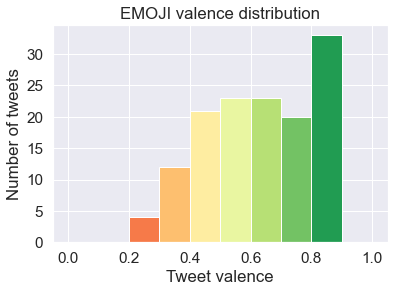

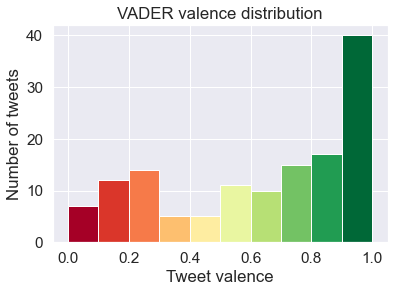

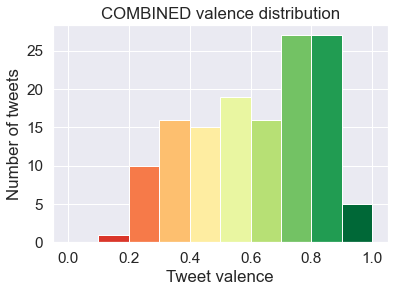

In [20]:
scores = ["EMOJI valence", "VADER valence", "COMBINED valence"]
for score in scores:
    title = score + " distribution"
    plot_hist(dataframe=df_test, title=title, column=score, bins=10)

## Evaluation
Here the different types metric types will be compared to the gold ground truth, i.e. the human annotated labels. Using the hyperparameter tuned version of the COMBINED approximation method, and the normal VADER and EMOJI-based rankings. 
### Regression

Emoji-based Pearson Correlation Coefficient: 	 0.6285225124024953
VADER-based Pearson Correlation Coefficient: 	 0.6663828347553832
Combined Pearson Correlation Coefficient:    	 0.7243556366871382


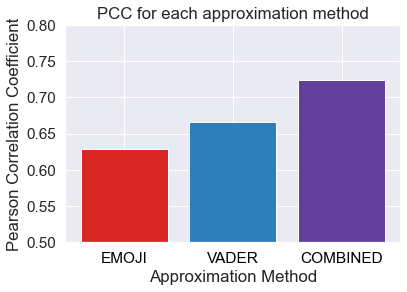

In [21]:
scores = ["EMOJI valence", "VADER valence", "COMBINED valence"]
correlations = [df_test["Ground Truth"].corr(df_test[score], method="pearson") for score in scores]

print("Emoji-based Pearson Correlation Coefficient: \t", correlations[0])
print("VADER-based Pearson Correlation Coefficient: \t", correlations[1])
print("Combined Pearson Correlation Coefficient:    \t", correlations[2])

y_pos = np.arange(len(correlations))

# rgb(251, 108, 76)
# rgb(111, 176, 215)
# rgb(159, 156, 201)
col=[(251/255, 108/255, 76/255),(111/255, 176/255, 215/255),(159/255, 156/255, 201/255)]
col=[(218/255, 39/255, 35/255),(46/255, 126/255, 188/255),(97/255, 64/255, 155/255)]
# rgb(218, 39, 35)
# rgb(46, 126, 188)
# rgb(97, 64, 155)

plt.bar(y_pos, correlations, color=col, edgecolor='white')
scores_edit = ["EMOJI", "VADER", "COMBINED"]
plt.xticks(y_pos, scores_edit, color='black')

plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Approximation Method')
plt.title('PCC for each approximation method')

plt.ylim([0.5, 0.8])
plt.show()

### Classification

In [22]:
classes = ["EMOJI Class", "VADER Class", "COMBINED Class"]
f1_scores = [f1_score(df_test["Ground Truth Class"], df_test[clas], average='micro') for clas in classes]

print("Emoji-based F1-score: \t", f1_scores[0])
print("VADER-based F1-score: \t", f1_scores[1])
print("Combined F1-score:    \t", f1_scores[2])

Emoji-based F1-score: 	 0.6102941176470589
VADER-based F1-score: 	 0.6323529411764706
Combined F1-score:    	 0.625


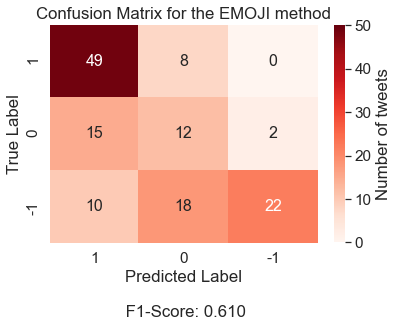

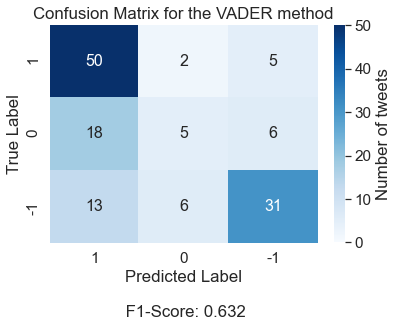

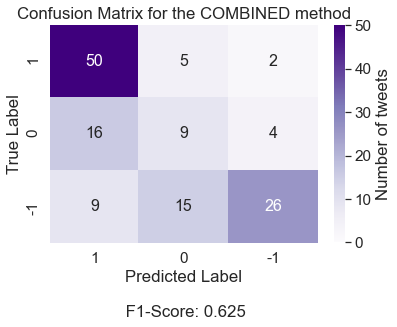

In [23]:
confusion_matrices = [confusion_matrix(df_test["Ground Truth Class"], df_test[clas], labels=[1, 0, -1]) for clas in classes]
colors = ['Reds', 'Blues', 'Purples']
titles= ['Confusion Matrix for the EMOJI method',
      'Confusion Matrix for the VADER method',
      'Confusion Matrix for the COMBINED method']
for i in [0,1,2]:
    sn.set(font_scale=1.4) # for label size
    ax = sn.heatmap(confusion_matrices[i],vmin=0, vmax=50, annot=True, annot_kws={"size": 16}, cbar=True,cbar_kws={'label': 'Number of tweets'}, cmap=colors[i], xticklabels=[1, 0, -1], yticklabels=[1, 0, -1]) # font size
    ax.set(xlabel='Predicted Label\n\n F1-Score: ' + str(f1_scores[i])[0:5], ylabel='True Label')
    ax.set_title(titles[i])
    plt.show()